## Quantium Virtual Internship - Retail Strategy and Analytics - Task 1

This Jupyter notebook follows a solution scaffold converted from R for Python for the task provided.

In [2]:
import pandas as pd

In [3]:
# Set up the dataframes
purchase_behaviour_df = pd.read_csv("C:/Users/Jacqu/OneDrive/Documents/Employment/Quantium/QuantiumVEP/Task1/QVI_purchase_behaviour.csv")
transaction_data_df = pd.read_excel("C:/Users/Jacqu/OneDrive/Documents/Employment/Quantium/QuantiumVEP/Task1/QVI_transaction_data.xlsx")

### Exploratory Data Analysis

Let's first examine the transaction data.

In [4]:
# Check if the columns that are expected to be numeric are in numeric form
print("Purchase Behvaiour Datatypes: \n", purchase_behaviour_df.dtypes, "\n")
print("Transaction Data Datatypes: \n", transaction_data_df.dtypes)

Purchase Behvaiour Datatypes: 
 LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object 

Transaction Data Datatypes: 
 DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object


We know that if there is mixed datatypes, it will get stored as an object dtype. Thus, the numeric columns are all satisfactory, since they all int64 and float64 dtypes. it can be seen that the date data is stored in integer format, so let's convert it to date time. It is known that Excel dates begin on 30 Dec 1899, so we will use that as the origin.

In [5]:
transaction_data_df["DATE"] = pd.to_datetime(transaction_data_df["DATE"], origin="1899-12-30", unit="D")

# Check if the DATE column is now in the correct format:
transaction_data_df["DATE"].head()

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

Okay so it is in the correct format. Next, let's see a summary of the PROD_NAME column.

In [6]:
transaction_data_df["PROD_NAME"]

0           Natural Chip        Compny SeaSalt175g
1                         CCs Nacho Cheese    175g
2           Smiths Crinkle Cut  Chips Chicken 170g
3           Smiths Chip Thinly  S/Cream&Onion 175g
4         Kettle Tortilla ChpsHny&Jlpno Chili 150g
                            ...                   
264831     Kettle Sweet Chilli And Sour Cream 175g
264832               Tostitos Splash Of  Lime 175g
264833                    Doritos Mexicana    170g
264834     Doritos Corn Chip Mexican Jalapeno 150g
264835               Tostitos Splash Of  Lime 175g
Name: PROD_NAME, Length: 264836, dtype: object

So this definitely looks like we are looking at chips. Let's examine each word in PROD_NAME to see if there are any incorrect entries, such as products that are not chips.

In [7]:
product_words = transaction_data_df["PROD_NAME"].str.split(expand=True).stack().reset_index(drop=True)
product_words_df = pd.DataFrame({"words": product_words})
product_words_df.head()

,words
0,Natural
1,Chip
2,Compny
3,SeaSalt175g
4,CCs


As we are only interested in words that will tell us if the product is chips or not, let's remove all words with digits and special characters such as '&' from our set of product words.

In [8]:
import re
product_words_df = product_words_df[~product_words_df["words"].str.contains(r'\d|[^\w\s]', regex=True)]
product_words_df.head()

,words
0,Natural
1,Chip
2,Compny
4,CCs
5,Nacho


Let's look at the most common words by counting the number of times a word appears and sorting the dataframe 
by this frequency in order of highest to lowest frequency.

In [9]:
word_counts = product_words_df.groupby(['words']).size().reset_index(name='Count').sort_values(['Count'], ascending=False)
word_counts.head(10)

,words,Count
28,Chips,49770
70,Kettle,41288
126,Smiths,28860
117,Salt,27976
18,Cheese,27890
106,Pringles,25102
52,Doritos,24962
41,Crinkle,23960
38,Corn,22063
92,Original,21560


There are also salsa products in the dataset but we are only interested in the chips category, so let's remove these.

In [10]:
# Convert PROD_NAME column to lowercase
transaction_data_df["PROD_NAME"] = transaction_data_df["PROD_NAME"].str.lower()

# Remove salsa products
transaction_data_df= transaction_data_df[~transaction_data_df["PROD_NAME"].str.contains("salsa")]

Next, we can use 'describe()' to check summary statistics such as mean, min and max values for each 
feature to see if there are any obvious outliers in the data, and if there are any nulls in any of
the columns

In [11]:
transaction_data_df.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828


There are no nulls in the columns but the product quantity appears to have an outlier which we should
investigate further. Let's investigate further the case where 200 packets of chips are bought in one
transaction.

In [12]:
transaction_data_df.sort_values(by=['PROD_QTY'], ascending=False).head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69763,2019-05-20,226,226000,226210,4,dorito corn chp supreme 380g,200,650.0
69762,2018-08-19,226,226000,226201,4,dorito corn chp supreme 380g,200,650.0
135225,2019-05-15,46,46296,42138,81,pringles original crisps 134g,5,18.5
69523,2019-05-15,71,71142,69852,96,ww original stacked chips 160g,5,9.5
69502,2018-08-18,55,55144,49328,44,thins chips light& tangy 175g,5,16.5


There are two transactions where 200 packets of chips are bought in one transaction and both of 
these transactions were made by the same customer. Let's see if the customer has had any other
transactions.

In [13]:
transaction_data_df.loc[transaction_data_df['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,dorito corn chp supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,dorito corn chp supreme 380g,200,650.0


It looks like this customer has only had the two transactions over the year and is
not an ordinary retail customer. The customer might be buying chips for commercial
purposes instead. We'll remove this loyalty card number from further analysis.

In [16]:
transaction_data_df = transaction_data_df.drop(transaction_data_df[transaction_data_df['LYLTY_CARD_NBR'] == 226000].index)

In [18]:
transaction_data_df.sort_values(by=['PROD_QTY'], ascending=False).head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
80732,2019-05-18,49,49309,45816,30,doritos corn chips cheese supreme 170g,5,22.0
17145,2018-08-16,202,202289,202104,42,doritos corn chip mexican jalapeno 150g,5,19.5
117547,2019-05-19,81,81120,80285,46,kettle original 175g,5,27.0
99458,2018-08-17,138,138085,141016,40,thins chips seasonedchicken 175g,5,16.5
28135,2018-08-20,51,51263,46961,3,kettle sensations camembert & fig 150g,5,23.0
32773,2019-05-16,230,230068,232345,100,smiths crinkle cut chips chs&onion170g,5,14.5
99461,2018-08-16,141,141276,142536,25,pringles sourcream onion 134g,5,18.5
99468,2018-08-14,144,144113,144496,15,twisties cheese 270g,5,23.0
81110,2018-08-17,181,181129,183109,23,cheezels cheese 330g,5,28.5
117935,2019-05-14,226,226193,227260,40,thins chips seasonedchicken 175g,5,16.5


That's better. Now, let's look at the number of transaction lines over time to see
if there are any obvious data issues such as missing data.

In [28]:
date_counts = transaction_data_df.groupby(['DATE']).size().reset_index(name='Count').sort_values(['Count'], ascending=False)
print(date_counts.count())
date_counts.head(10)

DATE     364
Count    364
dtype: int64


,DATE,Count
176,2018-12-24,865
175,2018-12-23,853
174,2018-12-22,840
171,2018-12-19,839
172,2018-12-20,808
170,2018-12-18,799
173,2018-12-21,781
340,2019-06-07,762
67,2018-09-06,745
347,2019-06-14,743


There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's
create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a
chart of number of transactions over time to find the missing date.

In [32]:
date_counts.sort_values(by=['DATE'], ascending=True)

,DATE,Count
0,2018-07-01,663
1,2018-07-02,650
2,2018-07-03,674
3,2018-07-04,669
4,2018-07-05,660
...,...,...
359,2019-06-26,657
360,2019-06-27,669
361,2019-06-28,673
362,2019-06-29,703


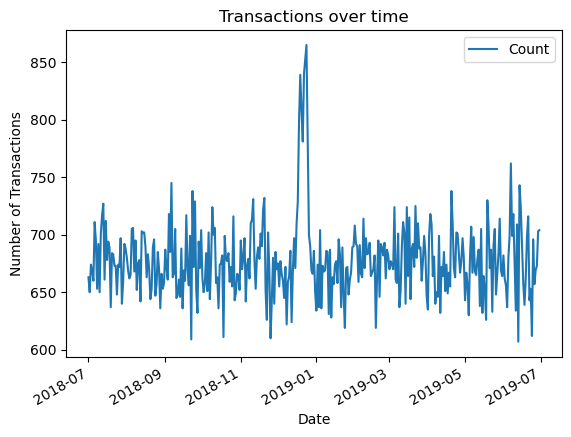

In [36]:
import matplotlib.pyplot as plt
date_counts.plot(x = 'DATE', y = 'Count')
plt.title('Transactions over time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

We can see that there is an increase in purchases in December and a break in late
December. Let's zoom in on this.